# Access to roads in Guatemala

Lots of communities in Guatemala lack good access to roads. This analysis began as a way to measure how access to public ways is in municipalities. At first I tried Open Street Maps data, however when comparing to official roads data, it can be seen OSM does not have all roads and it has streets data for some few places. Thus, the only reliable data we can obtain about this subject comes from official IGN (national geography institute) data, which does not have streets data. This limits our analysis to roads. The outcome we want to measure was what is the proportion of people that live near a street. This outcome is very important for health seeking beahviour, and in general for access to most economical and social activities such as labor, consumption, trading, education and transportation. However, with highway and minor roads data all we can aspire to is to the outcome of: what proportion of people live near a primary or secondary road. 

First I am going to show the analysis on OSM data and after that I will show the IGN data analysis. Both analysis are the same. Only change is the original data. 

For population estimations I have used Worldpop project data. This brings an issue with this analysis: worldpop uses roads data to estimate population density. However, there are lots of other factos worldpop manages, such as poverty, night lights, deforestation, and many others. 

All this makes this analysis very unconclusive and generates more questions than answers. Anyway, it has been a nice exercise to learn more about Fiona, Rasterio and GeoPandas.

In [1]:
import fiona
import rasterio
import rasterio.features
from rasterio import mask
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import scipy.ndimage as ndi
import re

%matplotlib inline

# Using OSM data

In [8]:
# gtmr = fiona.open("../DATOS/OSM/hotosm_gtm_roads_lines.shp/hotosm_gtm_roads_lines.shp")
gtroads_osm = geopandas.read_file("../../../DATOS/OSM/hotosm_gtm_roads_lines.shp/hotosm_gtm_roads_lines.shp")

In [9]:
print("Number of features in roads map: ", len(gtroads_osm))
gtroads_osm.head()

Number of features in roads map:  107488


,osm_id,name,highway,surface,smoothness,width,lanes,oneway,bridge,layer,z_index,geometry
0,4426020,4a Avenida,residential,asphalt,,,,yes,,,3,"LINESTRING (-90.5329559 14.6018449, -90.532218..."
1,4426038,5a Avenida,residential,asphalt,,,,yes,,,3,"LINESTRING (-90.52873630000001 14.6038369, -90..."
2,4813484,,trunk,asphalt,,,3,yes,,1,18,"LINESTRING (-90.7120735 14.4016481, -90.711672..."
3,8409108,3a Calle,residential,asphalt,,,,yes,,,3,"LINESTRING (-90.5325854 14.6043002, -90.532034..."
4,8409110,1a Calle,residential,asphalt,,,1,yes,,,3,"LINESTRING (-90.5316783 14.6060229, -90.531145..."


In [10]:
gtroads_osm.highway.value_counts(dropna=False).sort_index()

bridleway            31
construction         20
corridor              2
cycleway              8
escape                1
footway            1109
living_street      1299
motorway_link         3
path               2304
pedestrian          450
primary            1067
primary_link        256
raceway               9
residencial           1
residential       63373
road                137
secondary          2147
secondary_link      262
service            5454
services              1
steps               116
tertiary           3701
tertiary_link       119
track             13014
trunk               568
trunk_link          719
unclassified      11317
Name: highway, dtype: int64

In [12]:
wpgt_file = "../../../DATOS/WorldPop/GTM_ppp_v2b_2015/GTM_ppp_v2b_2015.tif"
wpgt_r = rasterio.open(wpgt_file)
wpgt = wpgt_r.read()
wpgt_r.bounds

BoundingBox(left=-92.24071231229665, bottom=13.738426751815744, right=-88.22087311229664, top=17.81909685181575)

In [13]:
rasterizado = rasterio.features.rasterize(
    [(x.geometry, 1) for i, x in gtroads_osm.iterrows()],
    out_shape=wpgt_r.shape,
    transform=wpgt_r.transform,
    fill=0,
    all_touched=True, 
    dtype=rasterio.uint8, )

/home/guillermo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/rasterio/features.py:303: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


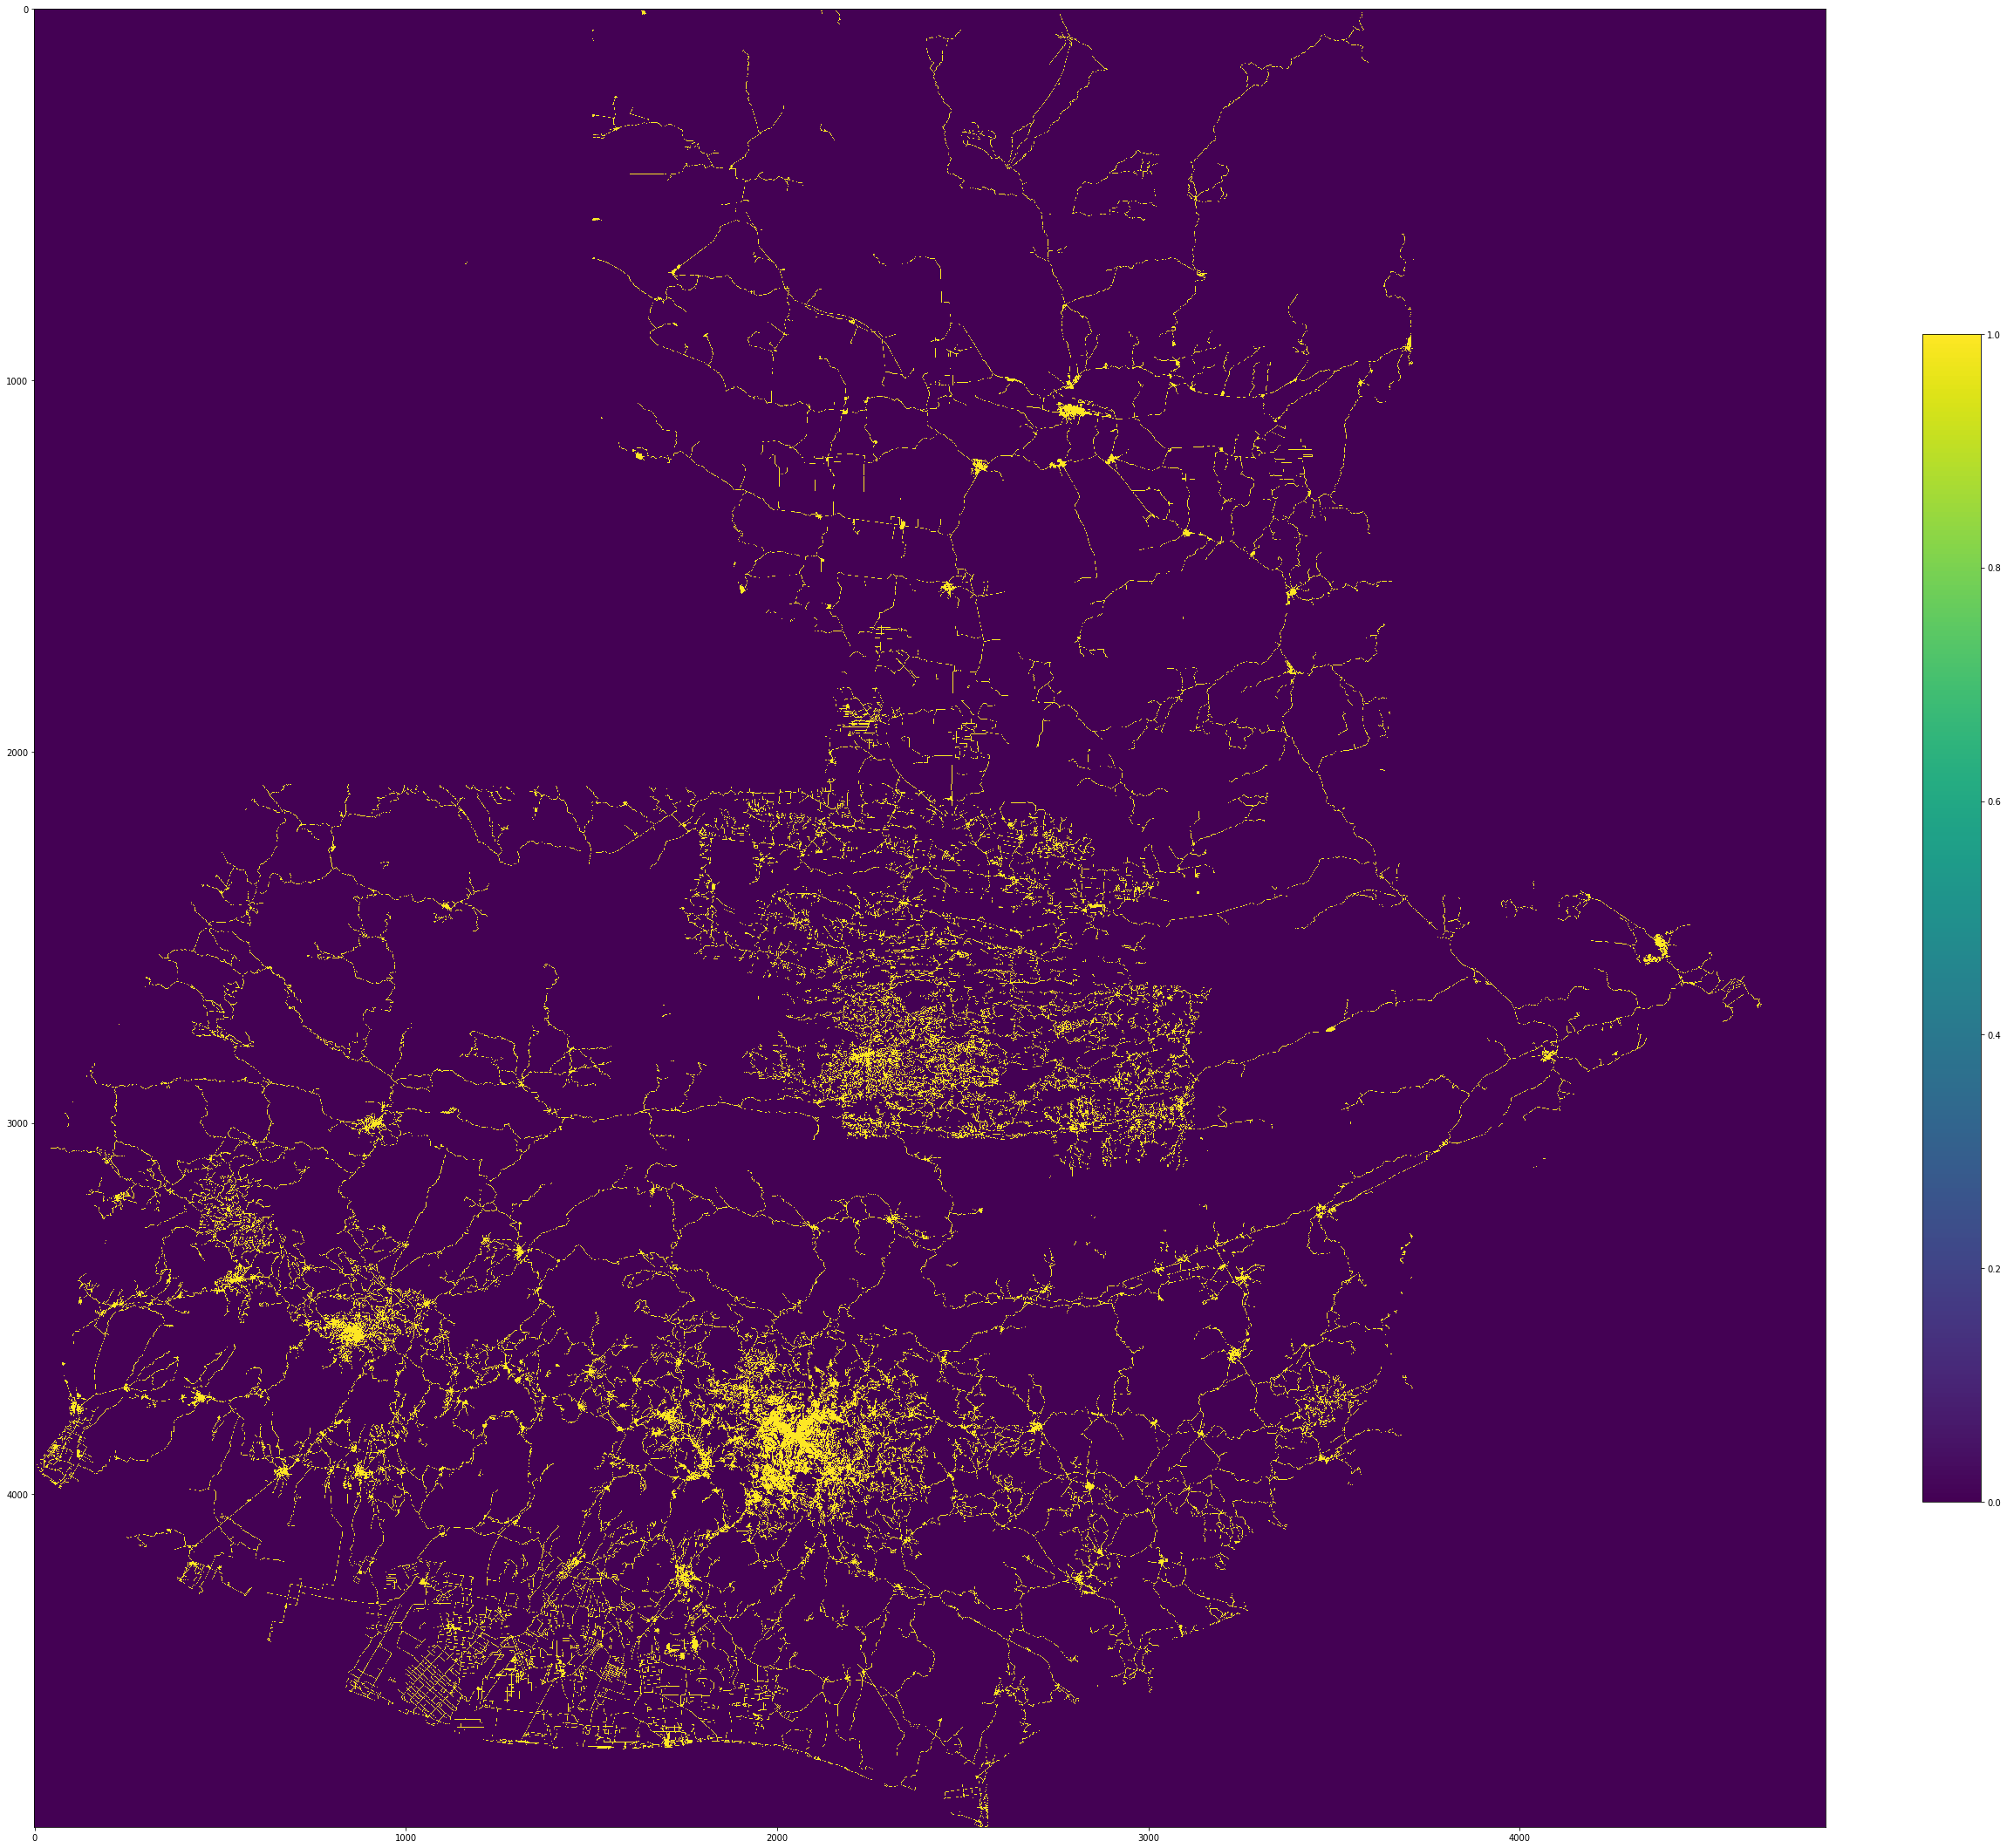

In [14]:
plt.rcParams['figure.figsize'] = 40, 40
plt.imshow(rasterizado, )
bar = plt.colorbar(fraction=0.03)

In [15]:
# To write the rasterized map to a file:
profile = wpgt_r.profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw', 
    nodata=0)
rasterizado[rasterizado < 1] = 0
with rasterio.open("GtRoads_OSM_100m_x_100m.tif", 'w', **profile) as out:
    out.write_band(1, rasterizado)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [16]:
# I have not found a way to get a raster from in memory data. So I have loaded it from the file written above.
gtroads_osm_raster = rasterio.open("GtRoads_OSM_100m_x_100m.tif", 'r')
gtroads_osm_r = gtroads_osm_raster.read()

In [17]:
gtroads_osm_filtered = ndi.maximum_filter(gtroads_osm_r, size= 5 )

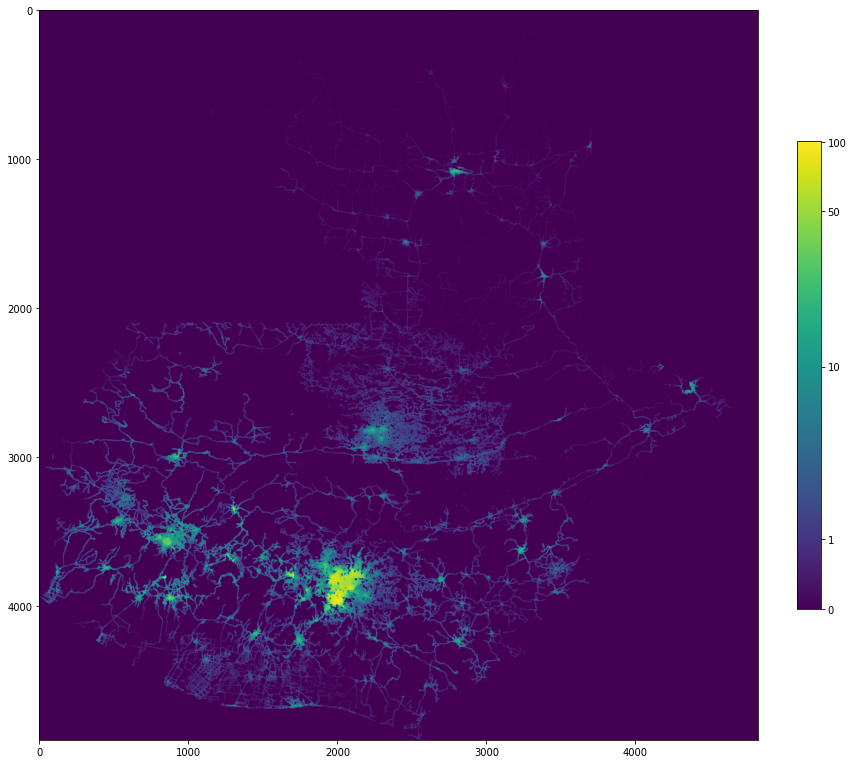

In [18]:
gtroads_access_osm = wpgt[0] * gtroads_osm_filtered[0]

plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10((np.fmax( gtroads_access_osm+1, 1))), vmin = 0, interpolation="bilinear")
bar = plt.colorbar(fraction=0.03)
bar.set_ticks([0, 0.301, 1.041, 1.708, 2.0043])
bar.set_ticklabels([0, 1, 10, 50, 100])

In [19]:
# Now let's get Guatemala municipalities shapes
gpmunis_json = fiona.open("../../../DATOS/IGN/GT-IGN-cartografia_basica-Division politica Administrativa (Municipios).geojson", "r", "GeoJSON")
gpmunis = geopandas.GeoDataFrame.from_features(gpmunis_json)

In [20]:
munis_pop = []
for muni in gpmunis_json:
    subr, bounds = mask.mask(wpgt_r, [muni["geometry"]])
    munis_pop.append({
        "road_access": np.sum(gtroads_access_osm[subr.data[0]>0]),
        "total_pop": np.sum(subr.data[subr.data>0]),
        "codigo": muni["properties"]["COD_MUNI__"]
    }) 
    print("processes muni ", muni["properties"]["COD_MUNI__"])

processes muni  0
processes muni  2000
processes muni  1420
processes muni  1326
processes muni  1615
processes muni  1318
processes muni  1305
processes muni  1601
processes muni  1801
processes muni  1802
processes muni  1614
processes muni  1325
processes muni  1802
processes muni  1317
processes muni  1413
processes muni  1307
processes muni  1331
processes muni  1313
processes muni  1405
processes muni  1609
processes muni  1314
processes muni  1415
processes muni  1612
processes muni  1324
processes muni  1308
processes muni  1312
processes muni  1803
processes muni  1323
processes muni  1611
processes muni  1804
processes muni  1302
processes muni  1311
processes muni  1304
processes muni  1419
processes muni  1805
processes muni  1608
processes muni  1607
processes muni  1327
processes muni  1316
processes muni  1309
processes muni  1320
processes muni  1603
processes muni  1411
processes muni  1319
processes muni  1610
processes muni  1328
processes muni  1321
processes muni  

In [21]:
mpdf = pd.DataFrame(munis_pop)

In [22]:
mpdf["perc_access"] = mpdf.road_access / mpdf.total_pop
mpdf.groupby(mpdf.codigo.apply(lambda x: x[0:-2] if len(x) >= 3 else "NA")).perc_access.describe()

,count,mean,std,min,25%,50%,75%,max
codigo,,,,,,,,
1,17.0,0.769990,0.168643,0.435911,0.662538,0.802281,0.926758,0.965864
10,21.0,0.385967,0.193431,0.098652,0.231973,0.389255,0.450695,0.765305
11,9.0,0.387778,0.149207,0.166449,0.291325,0.366561,0.446425,0.672127
12,30.0,0.356090,0.171257,0.134105,0.198029,0.344035,0.463368,0.697507
13,33.0,0.139945,0.095562,0.000000,0.096134,0.123086,0.159031,0.397773
14,21.0,0.192583,0.120880,0.038551,0.108379,0.150914,0.251017,0.484643
15,8.0,0.167665,0.053554,0.084035,0.134963,0.171178,0.203613,0.236474
16,17.0,0.478569,0.164877,0.086734,0.394829,0.475044,0.546827,0.832577
17,14.0,0.218950,0.111254,0.114244,0.144242,0.197655,0.248861,0.549988


In [23]:
gpmunis_osm = gpmunis.copy().merge(mpdf, left_on="COD_MUNI__", right_on="codigo", how="left")

No handles with labels found to put in legend.


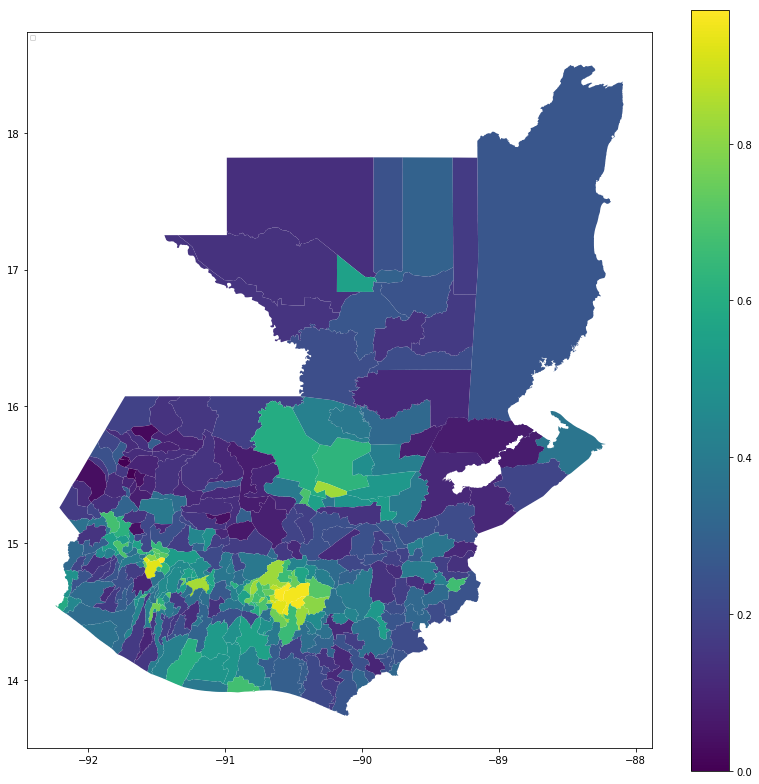

In [24]:
plt.rcParams['figure.figsize'] = 14, 14

plot = gpmunis_osm.plot(column = "perc_access", legend= True)
plot.legend(loc=2, prop={'size': 6})


In [30]:
gpmunis_osm.to_csv("gt_municipalities_roads_300m_OSM.csv", 
                   columns=["COD_MUNI__", "perc_access", "road_access", "total_pop"])

# Using IGN data

In [38]:
gtroads_ign = geopandas.read_file("../../../DATOS/IGN/IGN-cartografia_basica-Red de CArreteras.geojson", 
                                  mode="r", driver="GeoJSON")

In [39]:
print(len(gtroads_ign))
gtroads_ign.head()

1133


,title,link,guid,description,geometry
0,Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,"<h4>Red de CArreteras</h4>\n\n<ul class=""texta...",LINESTRING (-90.52848261399993 14.603730129000...
1,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-90.52848261399993 14.603730129000...
2,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-90.52848261399993 14.603730129000...
3,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-91.58240251699993 15.333519928000...
4,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-91.58240251699993 15.333519928000...


In [50]:
# IGN data has properties encoded in raw html. IGN sucks >:(
prev = None
def process_description_in_ugly_ign_format(input_str):
    if not input_str.startswith("Continuation"):
        return pd.Series(index = re.findall("atr-name\"\>([\w ]*)\<", input_str), 
                         data = re.findall("atr-value\"\>([^\<]*)\<", input_str))
    return pd.Series([])
    
properties = \
    gtroads_ign.description.apply(process_description_in_ugly_ign_format).fillna(method="ffill")
gtroads_ign = gtroads_ign.merge(properties, left_index=True, right_index=True)

In [51]:
gtroads_ign.head()

,title,link,guid,description,geometry,Categoria,Descripcio,NIVEL,NOMBRE,PAIS,TIPO,long
0,Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,"<h4>Red de CArreteras</h4>\n\n<ul class=""texta...",LINESTRING (-90.52848261399993 14.603730129000...,1,CENTROAMERICANA,1,CA1,Guatemala,Pavimentada,997948.49749
1,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-90.52848261399993 14.603730129000...,1,CENTROAMERICANA,1,CA1,Guatemala,Pavimentada,997948.49749
2,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-90.52848261399993 14.603730129000...,1,CENTROAMERICANA,1,CA1,Guatemala,Pavimentada,997948.49749
3,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-91.58240251699993 15.333519928000...,1,CENTROAMERICANA,1,CA1,Guatemala,Pavimentada,997948.49749
4,Continuation of Red de CArreteras.1,http://www.ign.gob.gt:80/geoserver/cartografia...,http://www.ign.gob.gt:80/geoserver/cartografia...,Continuation of Red de CArreteras.1,LINESTRING (-91.58240251699993 15.333519928000...,1,CENTROAMERICANA,1,CA1,Guatemala,Pavimentada,997948.49749


In [55]:
rgtroads_ign = rasterio.features.rasterize(
    [(x.geometry, 1) for i,x in gtroads_ign.iterrows()],
    out_shape=wpgt_r.shape,
    transform=wpgt_r.transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.uint8, )

/home/guillermo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/rasterio/features.py:303: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


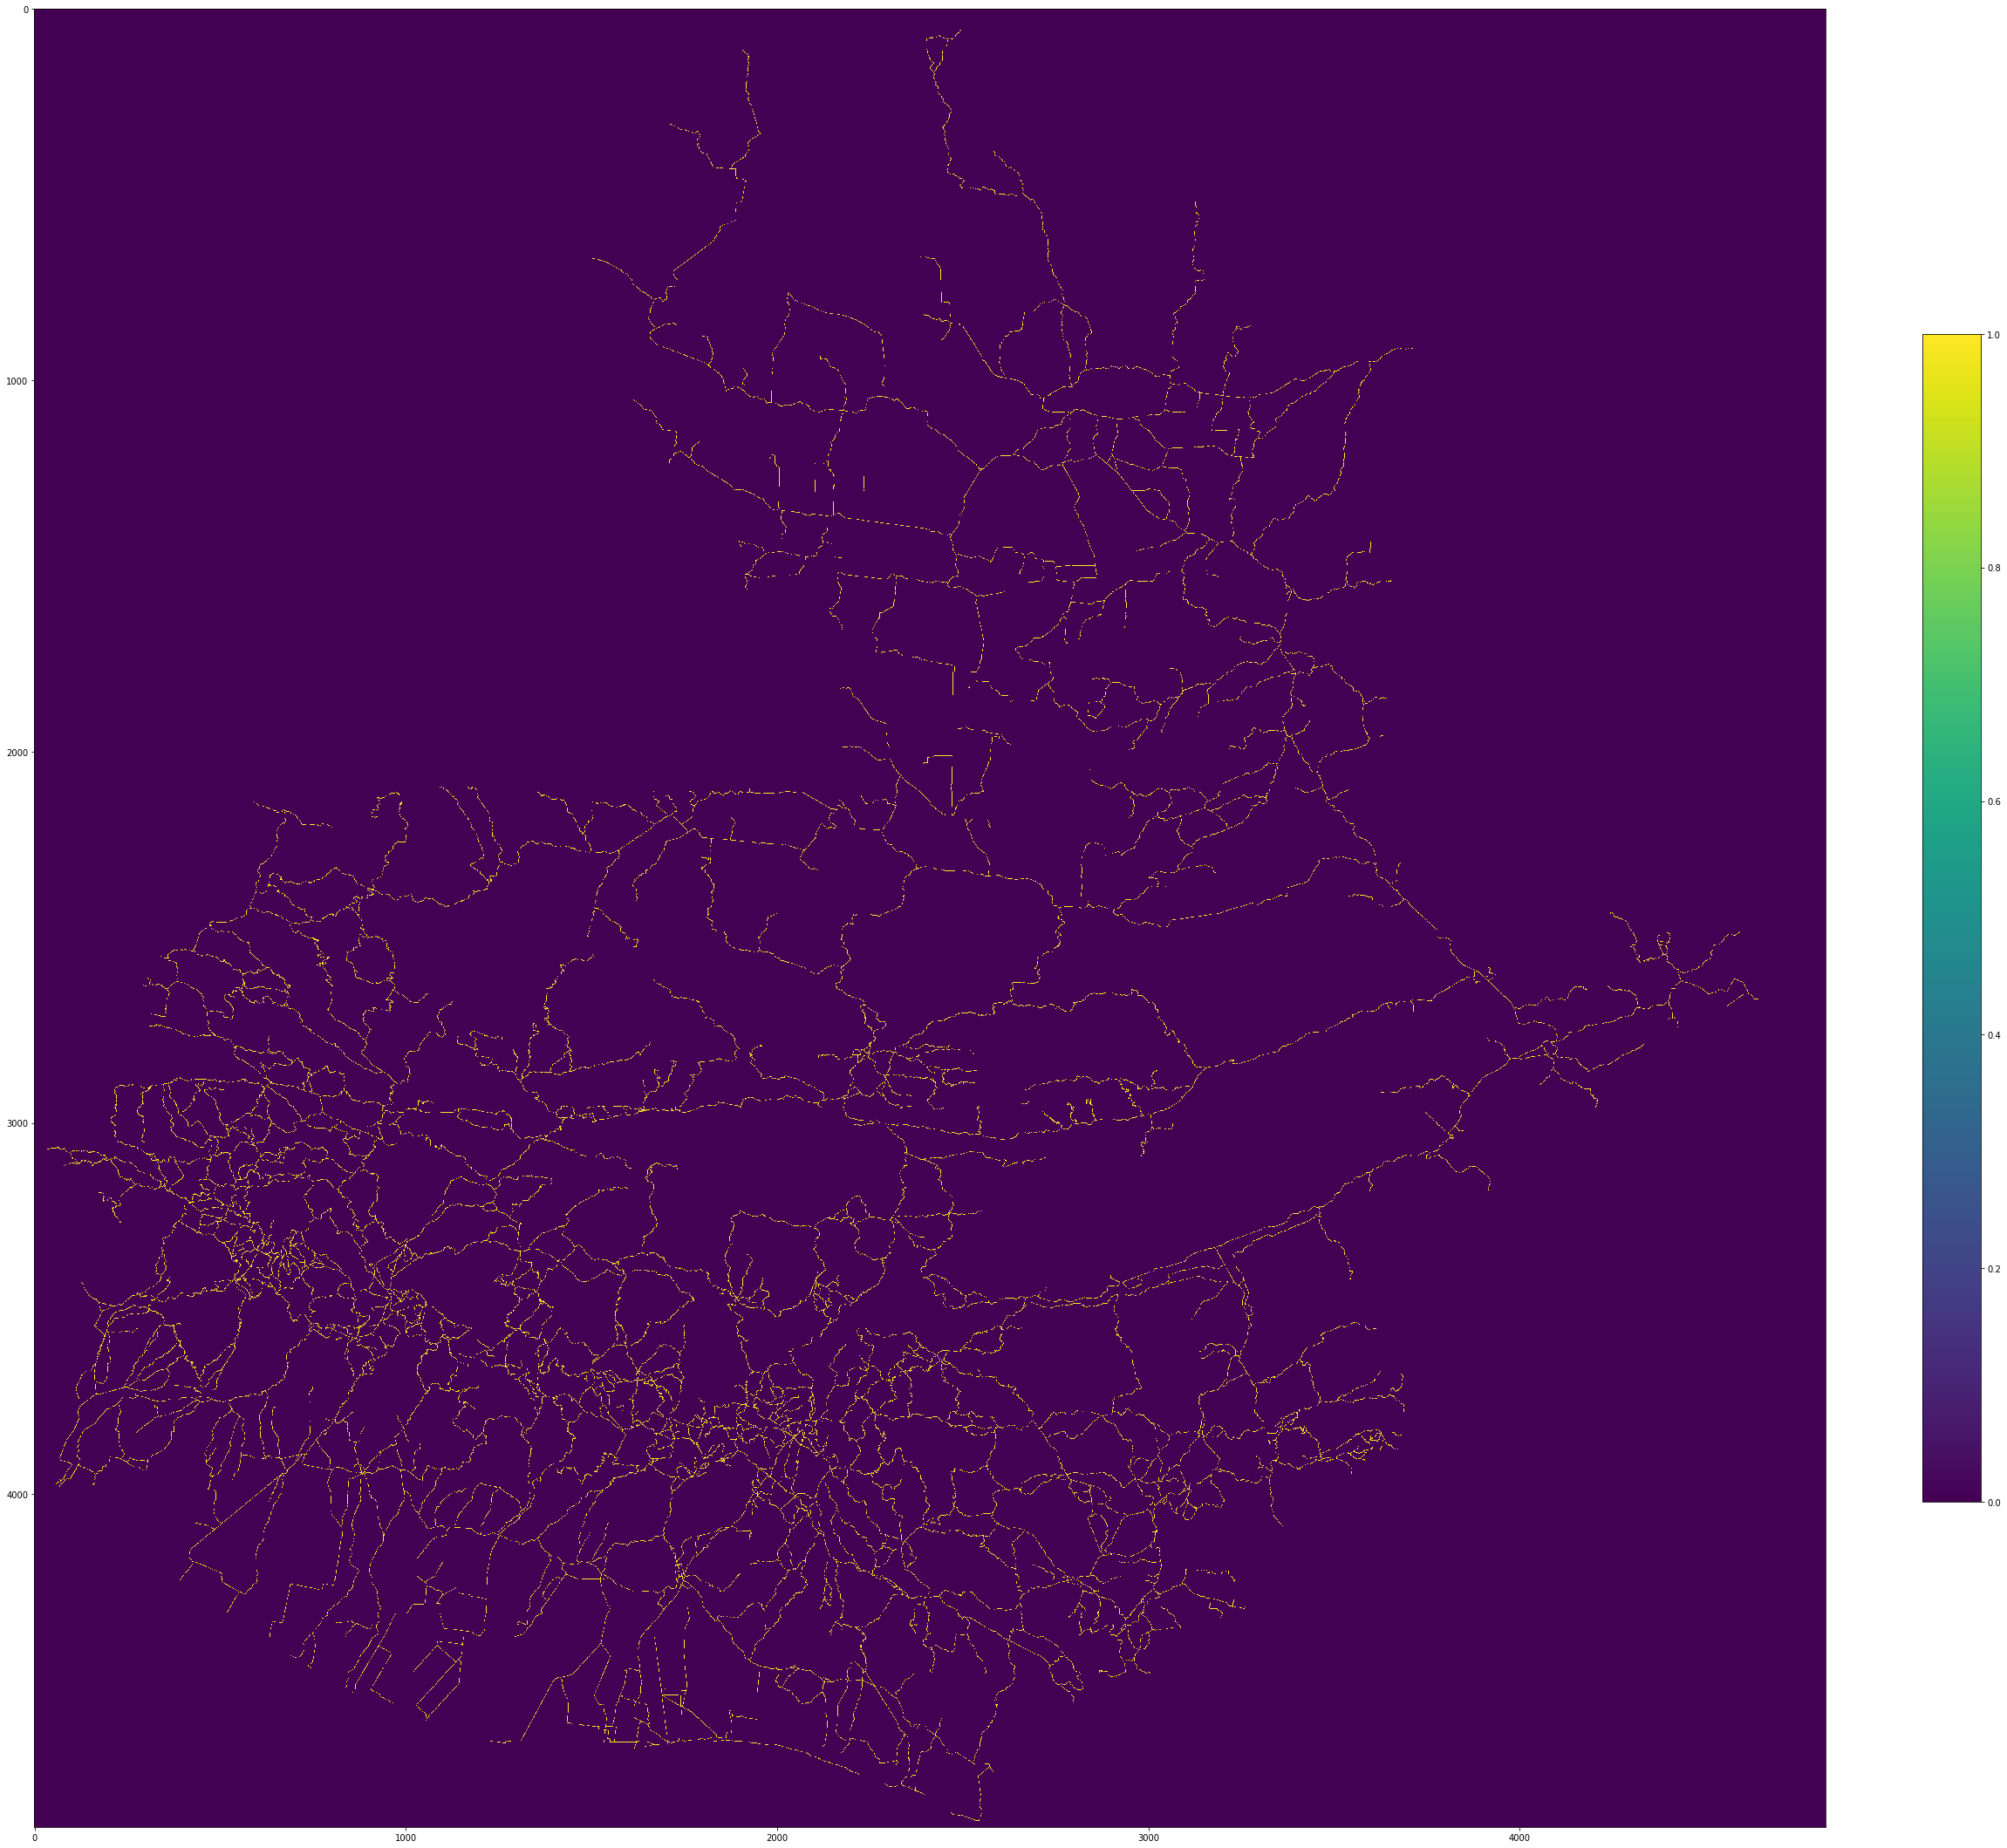

In [56]:
plt.rcParams['figure.figsize'] = 40, 40
plt.imshow(rgtroads_ign )
bar = plt.colorbar(fraction=0.03)

In [57]:
# To write the rasterized map to a file:
profile = wpgt_r.profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw', 
    nodata=0)
rgtroads_ign[rgtroads_ign < 1] = 0
with rasterio.open("GtRoads_IGN_100m_x_100m.tif", 'w', **profile) as out:
    out.write_band(1, rgtroads_ign)
    

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [60]:
gtroads_raster_ign = rasterio.open("GtRoads_IGN_100m_x_100m.tif", 'r')
gtroads_ign_rdata = gtroads_raster_ign.read()

In [61]:
gtroads_ign_filtered = ndi.maximum_filter(gtroads_ign_rdata, size= 5 )

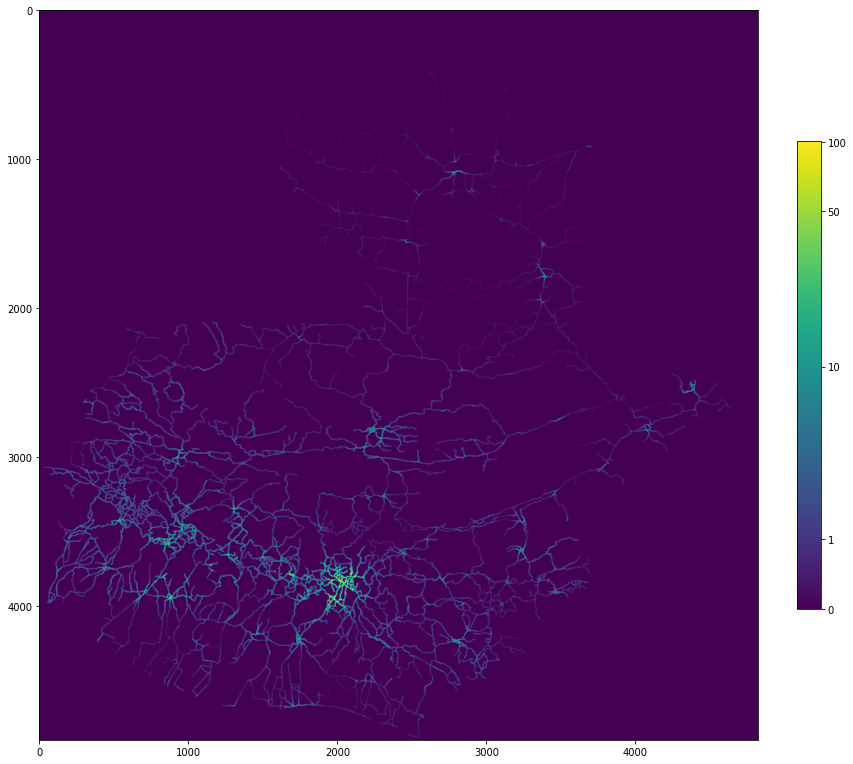

In [62]:
gtroads_access_ign = wpgt[0] * gtroads_ign_filtered[0]

plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10((np.fmax( gtroads_access_ign+1, 1))), vmin = 0, interpolation="bilinear")
bar = plt.colorbar(fraction=0.03)
bar.set_ticks([0, 0.301, 1.041, 1.708, 2.0043])
bar.set_ticklabels([0, 1, 10, 50, 100])

In [63]:
munis_acc_ign = []
for muni in gpmunis_json:
    subr, bounds = mask.mask(wpgt_r, [muni["geometry"]])
    munis_acc_ign.append({
        "road_access" : np.sum(gtroads_access_ign[subr.data[0]>0]),
        "total_pop"   : np.sum(subr.data[subr.data>0]),
        "Codigo"      : muni["properties"]["COD_MUNI__"]
    })
    print("processes muni ", muni["properties"]["COD_MUNI__"])

processes muni  0
processes muni  2000
processes muni  1420
processes muni  1326
processes muni  1615
processes muni  1318
processes muni  1305
processes muni  1601
processes muni  1801
processes muni  1802
processes muni  1614
processes muni  1325
processes muni  1802
processes muni  1317
processes muni  1413
processes muni  1307
processes muni  1331
processes muni  1313
processes muni  1405
processes muni  1609
processes muni  1314
processes muni  1415
processes muni  1612
processes muni  1324
processes muni  1308
processes muni  1312
processes muni  1803
processes muni  1323
processes muni  1611
processes muni  1804
processes muni  1302
processes muni  1311
processes muni  1304
processes muni  1419
processes muni  1805
processes muni  1608
processes muni  1607
processes muni  1327
processes muni  1316
processes muni  1309
processes muni  1320
processes muni  1603
processes muni  1411
processes muni  1319
processes muni  1610
processes muni  1328
processes muni  1321
processes muni  

In [64]:
mpdf_ign = pd.DataFrame(munis_acc_ign)
mpdf_ign["perc_access"] = np.round(100 * mpdf_ign.road_access / mpdf_ign.total_pop)
mpdf_ign.groupby(mpdf_ign.Codigo.apply(lambda x: x[0:-2] if len(x) >= 3 else "NA")).perc_access.describe()

,count,mean,std,min,25%,50%,75%,max
Codigo,,,,,,,,
1,17.0,28.588235,7.525447,15.0,24.00,29.0,33.00,40.0
10,21.0,21.857143,8.621402,8.0,17.00,22.0,26.00,41.0
11,9.0,21.333333,9.797959,6.0,16.00,20.0,27.00,39.0
12,30.0,25.400000,9.510792,11.0,18.25,24.5,31.00,49.0
13,33.0,15.606061,6.661172,2.0,12.00,15.0,20.00,32.0
14,21.0,16.714286,8.337523,7.0,12.00,14.0,19.00,43.0
15,8.0,14.000000,6.524678,5.0,10.50,13.5,16.25,27.0
16,17.0,12.764706,5.471853,5.0,10.00,12.0,14.00,25.0
17,14.0,12.214286,4.245877,7.0,9.25,11.0,15.25,21.0


In [65]:

gpmunis_ign = gpmunis.copy().merge(mpdf_ign, left_on="COD_MUNI__", right_on="Codigo", how="left")


No handles with labels found to put in legend.


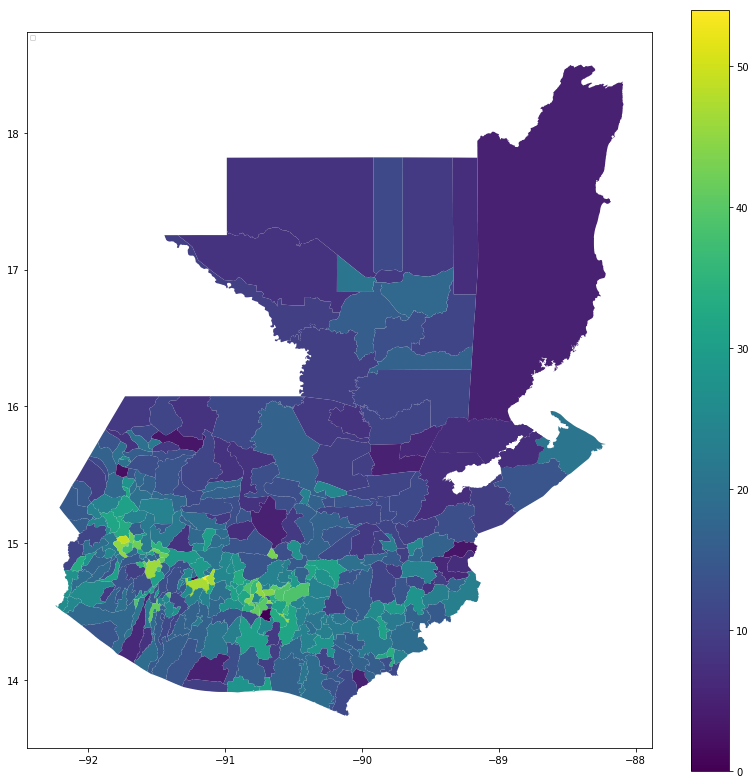

In [66]:
plt.rcParams['figure.figsize'] = 14, 14

plot = gpmunis_ign.plot(column = "perc_access", legend= True)
plot.legend(loc=2, prop={'size': 6})


In [68]:
gpmunis_ign.to_csv("gt_municipalities_roads_300m_IGN.csv", 
                   columns=["COD_MUNI__", "perc_access", "road_access", "total_pop"])